# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most strongly correlated with Consumption at t+3 (out of 100 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics most strongly correlated with Consumption at t+3, SentiWS (<=2007, 100 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "100"
source = "all"
selected = "_lag3"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11686
EM converged at iteration 56, llf=-11493, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-11699
EM converged at iteration 56, llf=-11505, convergence criterion=9.8129e-07 < tolerance=1e-06
EM start iterations, llf=-11759
EM converged at iteration 56, llf=-11563, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-11766
EM converged at iteration 56, llf=-11570, convergence criterion=9.8114e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM converged at iteration 57, llf=-11627, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-11834
EM converged at iteration 57, llf=-11634, convergence criterion=9.8909e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 57, llf=-11684, convergence criterion=9.8425e-07 < tolerance=1e-06
EM start iterations, llf=-11884
EM converged at iteration 57, llf=-11684, convergence criterion=9.8425e-07 < tolerance=1e-06


EM start iterations, llf=-13343
EM converged at iteration 49, llf=-13186, convergence criterion=9.6005e-07 < tolerance=1e-06
EM start iterations, llf=-13394
EM converged at iteration 47, llf=-13239, convergence criterion=9.8182e-07 < tolerance=1e-06
EM start iterations, llf=-13404
EM converged at iteration 47, llf=-13249, convergence criterion=9.79e-07 < tolerance=1e-06
EM start iterations, llf=-13458
EM converged at iteration 47, llf=-13300, convergence criterion=9.723e-07 < tolerance=1e-06
EM start iterations, llf=-13458
EM converged at iteration 47, llf=-13300, convergence criterion=9.723e-07 < tolerance=1e-06
EM start iterations, llf=-13470
EM converged at iteration 47, llf=-13312, convergence criterion=9.8144e-07 < tolerance=1e-06
EM start iterations, llf=-13518
EM converged at iteration 47, llf=-13360, convergence criterion=9.8508e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM converged at iteration 47, llf=-13366, convergence criterion=9.8393e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-15036
EM converged at iteration 48, llf=-14869, convergence criterion=9.8052e-07 < tolerance=1e-06
EM start iterations, llf=-15036
EM converged at iteration 48, llf=-14869, convergence criterion=9.8052e-07 < tolerance=1e-06
EM start iterations, llf=-15045
EM converged at iteration 48, llf=-14878, convergence criterion=9.8005e-07 < tolerance=1e-06
EM start iterations, llf=-15099
EM converged at iteration 48, llf=-14932, convergence criterion=9.7805e-07 < tolerance=1e-06
EM start iterations, llf=-15110
EM converged at iteration 48, llf=-14943, convergence criterion=9.7672e-07 < tolerance=1e-06
EM start iterations, llf=-15159
EM converged at iteration 48, llf=-14991, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-15167
EM converged at iteration 48, llf=-14999, convergence criterion=9.8312e-07 < tolerance=1e-06
EM start iterations, llf=-15213
EM converged at iteration 48, llf=-15045, convergence criterion=9.7838e-07 < tolerance=1e-06


EM start iterations, llf=-16741
EM converged at iteration 57, llf=-16558, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-16745
EM converged at iteration 57, llf=-16563, convergence criterion=9.9095e-07 < tolerance=1e-06
EM start iterations, llf=-16798
EM converged at iteration 58, llf=-16616, convergence criterion=9.6922e-07 < tolerance=1e-06
EM start iterations, llf=-16806
EM converged at iteration 58, llf=-16623, convergence criterion=9.6833e-07 < tolerance=1e-06
EM start iterations, llf=-16859
EM converged at iteration 57, llf=-16676, convergence criterion=9.9839e-07 < tolerance=1e-06
EM start iterations, llf=-16859
EM converged at iteration 57, llf=-16676, convergence criterion=9.9839e-07 < tolerance=1e-06
EM start iterations, llf=-16868
EM converged at iteration 57, llf=-16683, convergence criterion=9.9871e-07 < tolerance=1e-06
EM start iterations, llf=-16918
EM converged at iteration 57, llf=-16733, convergence criterion=9.9494e-07 < tolerance=1e-06


EM start iterations, llf=-18244
EM converged at iteration 59, llf=-18052, convergence criterion=9.7304e-07 < tolerance=1e-06
EM start iterations, llf=-18304
EM converged at iteration 58, llf=-18111, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-18304
EM converged at iteration 58, llf=-18111, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-18309
EM converged at iteration 58, llf=-18117, convergence criterion=9.9919e-07 < tolerance=1e-06
EM start iterations, llf=-18362
EM converged at iteration 58, llf=-18170, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-18369
EM converged at iteration 58, llf=-18177, convergence criterion=9.9628e-07 < tolerance=1e-06
EM start iterations, llf=-18426
EM converged at iteration 58, llf=-18233, convergence criterion=9.9564e-07 < tolerance=1e-06
EM start iterations, llf=-18434
EM converged at iteration 58, llf=-18240, convergence criterion=9.9556e-07 < tolerance=1e-06


EM start iterations, llf=-12228
EM converged at iteration 54, llf=-12005, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-12222
EM converged at iteration 54, llf=-11992, convergence criterion=9.6782e-07 < tolerance=1e-06
EM start iterations, llf=-12299
EM converged at iteration 53, llf=-12089, convergence criterion=9.9652e-07 < tolerance=1e-06
EM start iterations, llf=-12316
EM converged at iteration 53, llf=-12121, convergence criterion=9.7527e-07 < tolerance=1e-06
EM start iterations, llf=-12343
EM converged at iteration 53, llf=-12174, convergence criterion=9.6493e-07 < tolerance=1e-06
EM start iterations, llf=-12342
EM converged at iteration 52, llf=-12172, convergence criterion=9.8938e-07 < tolerance=1e-06
EM start iterations, llf=-12348
EM converged at iteration 52, llf=-12185, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-12348
EM converged at iteration 52, llf=-12185, convergence criterion=9.9737e-07 < tolerance=1e-06


EM start iterations, llf=-13880
EM converged at iteration 47, llf=-13723, convergence criterion=9.6572e-07 < tolerance=1e-06
EM start iterations, llf=-13920
EM converged at iteration 47, llf=-13763, convergence criterion=9.6898e-07 < tolerance=1e-06
EM start iterations, llf=-13923
EM converged at iteration 47, llf=-13765, convergence criterion=9.7899e-07 < tolerance=1e-06
EM start iterations, llf=-13981
EM converged at iteration 47, llf=-13822, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-13981
EM converged at iteration 47, llf=-13822, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-13991
EM converged at iteration 47, llf=-13832, convergence criterion=9.7401e-07 < tolerance=1e-06
EM start iterations, llf=-14019
EM converged at iteration 47, llf=-13860, convergence criterion=9.6884e-07 < tolerance=1e-06
EM start iterations, llf=-14027
EM converged at iteration 47, llf=-13868, convergence criterion=9.6706e-07 < tolerance=1e-06


EM start iterations, llf=-15586
EM converged at iteration 47, llf=-15411, convergence criterion=9.7208e-07 < tolerance=1e-06
EM start iterations, llf=-15586
EM converged at iteration 47, llf=-15411, convergence criterion=9.7208e-07 < tolerance=1e-06
EM start iterations, llf=-15595
EM converged at iteration 47, llf=-15422, convergence criterion=9.7076e-07 < tolerance=1e-06
EM start iterations, llf=-15647
EM converged at iteration 47, llf=-15473, convergence criterion=9.6441e-07 < tolerance=1e-06
EM start iterations, llf=-15650
EM converged at iteration 47, llf=-15476, convergence criterion=9.6642e-07 < tolerance=1e-06
EM start iterations, llf=-15707
EM converged at iteration 46, llf=-15533, convergence criterion=9.9681e-07 < tolerance=1e-06
EM start iterations, llf=-15712
EM converged at iteration 46, llf=-15538, convergence criterion=9.9706e-07 < tolerance=1e-06
EM start iterations, llf=-15756
EM converged at iteration 46, llf=-15582, convergence criterion=9.9549e-07 < tolerance=1e-06


EM start iterations, llf=-17285
EM converged at iteration 59, llf=-17097, convergence criterion=9.6905e-07 < tolerance=1e-06
EM start iterations, llf=-17290
EM converged at iteration 58, llf=-17103, convergence criterion=9.9993e-07 < tolerance=1e-06
EM start iterations, llf=-17343
EM converged at iteration 59, llf=-17155, convergence criterion=9.7466e-07 < tolerance=1e-06
EM start iterations, llf=-17352
EM converged at iteration 59, llf=-17163, convergence criterion=9.7468e-07 < tolerance=1e-06
EM start iterations, llf=-17398
EM converged at iteration 59, llf=-17209, convergence criterion=9.7243e-07 < tolerance=1e-06
EM start iterations, llf=-17398
EM converged at iteration 59, llf=-17209, convergence criterion=9.7243e-07 < tolerance=1e-06
EM start iterations, llf=-17417
EM converged at iteration 59, llf=-17229, convergence criterion=9.7058e-07 < tolerance=1e-06
EM start iterations, llf=-17469
EM converged at iteration 58, llf=-17280, convergence criterion=9.9623e-07 < tolerance=1e-06


EM start iterations, llf=-18791
EM converged at iteration 58, llf=-18593, convergence criterion=9.9436e-07 < tolerance=1e-06
EM start iterations, llf=-18840
EM converged at iteration 58, llf=-18641, convergence criterion=9.9217e-07 < tolerance=1e-06
EM start iterations, llf=-18840
EM converged at iteration 58, llf=-18641, convergence criterion=9.9217e-07 < tolerance=1e-06
EM start iterations, llf=-18847
EM converged at iteration 58, llf=-18648, convergence criterion=9.9185e-07 < tolerance=1e-06
EM start iterations, llf=-18903
EM converged at iteration 58, llf=-18703, convergence criterion=9.8886e-07 < tolerance=1e-06
EM start iterations, llf=-18912
EM converged at iteration 58, llf=-18712, convergence criterion=9.8863e-07 < tolerance=1e-06
EM start iterations, llf=-18965
EM converged at iteration 58, llf=-18765, convergence criterion=9.7411e-07 < tolerance=1e-06
EM start iterations, llf=-18974
EM converged at iteration 58, llf=-18774, convergence criterion=9.7322e-07 < tolerance=1e-06


EM start iterations, llf=-12687
EM converged at iteration 61, llf=-12532, convergence criterion=9.9121e-07 < tolerance=1e-06
EM start iterations, llf=-12691
EM converged at iteration 60, llf=-12536, convergence criterion=9.964e-07 < tolerance=1e-06
EM start iterations, llf=-12741
EM converged at iteration 59, llf=-12586, convergence criterion=9.9521e-07 < tolerance=1e-06
EM start iterations, llf=-12749
EM converged at iteration 60, llf=-12593, convergence criterion=9.6888e-07 < tolerance=1e-06
EM start iterations, llf=-12798
EM converged at iteration 56, llf=-12642, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-12809
EM converged at iteration 56, llf=-12654, convergence criterion=9.7274e-07 < tolerance=1e-06
EM start iterations, llf=-12865
EM converged at iteration 56, llf=-12710, convergence criterion=9.9243e-07 < tolerance=1e-06
EM start iterations, llf=-12865
EM converged at iteration 56, llf=-12710, convergence criterion=9.9243e-07 < tolerance=1e-06
E

EM start iterations, llf=-14378
EM converged at iteration 52, llf=-14219, convergence criterion=9.8058e-07 < tolerance=1e-06
EM start iterations, llf=-14430
EM converged at iteration 52, llf=-14270, convergence criterion=9.8722e-07 < tolerance=1e-06
EM start iterations, llf=-14439
EM converged at iteration 52, llf=-14279, convergence criterion=9.6576e-07 < tolerance=1e-06
EM start iterations, llf=-14493
EM converged at iteration 52, llf=-14332, convergence criterion=9.7838e-07 < tolerance=1e-06
EM start iterations, llf=-14493
EM converged at iteration 52, llf=-14332, convergence criterion=9.7838e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 52, llf=-14342, convergence criterion=9.8e-07 < tolerance=1e-06
EM start iterations, llf=-14556
EM converged at iteration 52, llf=-14395, convergence criterion=9.7799e-07 < tolerance=1e-06
EM start iterations, llf=-14565
EM converged at iteration 52, llf=-14405, convergence criterion=9.6534e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16129
EM converged at iteration 51, llf=-15958, convergence criterion=9.8402e-07 < tolerance=1e-06
EM start iterations, llf=-16129
EM converged at iteration 51, llf=-15958, convergence criterion=9.8402e-07 < tolerance=1e-06
EM start iterations, llf=-16139
EM converged at iteration 51, llf=-15968, convergence criterion=9.8301e-07 < tolerance=1e-06
EM start iterations, llf=-16192
EM converged at iteration 51, llf=-16020, convergence criterion=9.7936e-07 < tolerance=1e-06
EM start iterations, llf=-16200
EM converged at iteration 51, llf=-16029, convergence criterion=9.796e-07 < tolerance=1e-06
EM start iterations, llf=-16250
EM converged at iteration 51, llf=-16078, convergence criterion=9.7442e-07 < tolerance=1e-06
EM start iterations, llf=-16258
EM converged at iteration 51, llf=-16086, convergence criterion=9.7501e-07 < tolerance=1e-06
EM start iterations, llf=-16310
EM converged at iteration 51, llf=-16137, convergence criterion=9.6977e-07 < tolerance=1e-06
E

EM start iterations, llf=-17814
EM converged at iteration 61, llf=-17626, convergence criterion=9.8202e-07 < tolerance=1e-06
EM start iterations, llf=-17820
EM converged at iteration 61, llf=-17632, convergence criterion=9.8391e-07 < tolerance=1e-06
EM start iterations, llf=-17873
EM converged at iteration 61, llf=-17684, convergence criterion=9.9829e-07 < tolerance=1e-06
EM start iterations, llf=-17880
EM converged at iteration 61, llf=-17692, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-17935
EM converged at iteration 61, llf=-17746, convergence criterion=9.9654e-07 < tolerance=1e-06
EM start iterations, llf=-17935
EM converged at iteration 61, llf=-17746, convergence criterion=9.9654e-07 < tolerance=1e-06
EM start iterations, llf=-17940
EM converged at iteration 61, llf=-17751, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-17992
EM converged at iteration 61, llf=-17802, convergence criterion=9.8943e-07 < tolerance=1e-06
E

EM start iterations, llf=-19049
EM converged at iteration 61, llf=-18853, convergence criterion=9.9757e-07 < tolerance=1e-06
EM start iterations, llf=-19102
EM converged at iteration 61, llf=-18906, convergence criterion=9.9537e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:52:15.113083.
EM start iterations, llf=-11197
EM converged at iteration 55, llf=-11061, convergence criterion=9.7837e-07 < tolerance=1e-06
EM start iterations, llf=-11210
EM converged at iteration 55, llf=-11074, convergence criterion=9.735e-07 < tolerance=1e-06
EM start iterations, llf=-11265
EM converged at iteration 55, llf=-11129, convergence criterion=9.7138e-07 < tolerance=1e-06
EM start iterations, llf=-11273
EM converged at iteration 55, llf=-11136, convergence criterion=9.6888e-07 < tolerance=1e-06
EM start iterations, llf=-11326
EM converged at iteration 54, llf=-11191, convergence criterion=9.8488e-07 < tolerance=1e-06
EM start iterations, llf=-11336
EM converged at itera

EM converged at iteration 48, llf=-12483, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-12642
EM converged at iteration 49, llf=-12494, convergence criterion=9.5878e-07 < tolerance=1e-06
EM start iterations, llf=-12673
EM converged at iteration 48, llf=-12530, convergence criterion=9.8136e-07 < tolerance=1e-06
EM start iterations, llf=-12676
EM converged at iteration 48, llf=-12533, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-12736
EM converged at iteration 46, llf=-12593, convergence criterion=9.757e-07 < tolerance=1e-06
EM start iterations, llf=-12737
EM converged at iteration 46, llf=-12595, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-12778
EM converged at iteration 46, llf=-12636, convergence criterion=9.6992e-07 < tolerance=1e-06
EM start iterations, llf=-12778
EM converged at iteration 46, llf=-12636, convergence criterion=9.6992e-07 < tolerance=1e-06
EM start iterations, llf=-12783
E

EM start iterations, llf=-14185
EM converged at iteration 45, llf=-14036, convergence criterion=9.6808e-07 < tolerance=1e-06
EM start iterations, llf=-14239
EM converged at iteration 46, llf=-14091, convergence criterion=9.7535e-07 < tolerance=1e-06
EM start iterations, llf=-14247
EM converged at iteration 46, llf=-14099, convergence criterion=9.7693e-07 < tolerance=1e-06
EM start iterations, llf=-14301
EM converged at iteration 46, llf=-14154, convergence criterion=9.7079e-07 < tolerance=1e-06
EM start iterations, llf=-14301
EM converged at iteration 46, llf=-14154, convergence criterion=9.7079e-07 < tolerance=1e-06
EM start iterations, llf=-14308
EM converged at iteration 46, llf=-14162, convergence criterion=9.6827e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM converged at iteration 46, llf=-14213, convergence criterion=9.6195e-07 < tolerance=1e-06
EM start iterations, llf=-14368
EM converged at iteration 46, llf=-14221, convergence criterion=9.5986e-07 < tolerance=1e-06


EM start iterations, llf=-15870
EM converged at iteration 55, llf=-15712, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-15870
EM converged at iteration 55, llf=-15712, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-15884
EM converged at iteration 55, llf=-15726, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-15943
EM converged at iteration 55, llf=-15786, convergence criterion=9.9311e-07 < tolerance=1e-06
EM start iterations, llf=-15944
EM converged at iteration 55, llf=-15788, convergence criterion=9.9817e-07 < tolerance=1e-06
EM start iterations, llf=-15996
EM converged at iteration 56, llf=-15840, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-16003
EM converged at iteration 56, llf=-15847, convergence criterion=9.7942e-07 < tolerance=1e-06
EM start iterations, llf=-16052
EM converged at iteration 55, llf=-15898, convergence criterion=9.986e-07 < tolerance=1e-06
E

EM start iterations, llf=-17300
EM converged at iteration 56, llf=-17143, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-17316
EM converged at iteration 56, llf=-17157, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-17374
EM converged at iteration 56, llf=-17214, convergence criterion=9.9663e-07 < tolerance=1e-06
EM start iterations, llf=-17378
EM converged at iteration 56, llf=-17218, convergence criterion=9.9591e-07 < tolerance=1e-06
EM start iterations, llf=-17436
EM converged at iteration 56, llf=-17276, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-17436
EM converged at iteration 56, llf=-17276, convergence criterion=9.9145e-07 < tolerance=1e-06
EM start iterations, llf=-17441
EM converged at iteration 56, llf=-17281, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-17491
EM converged at iteration 56, llf=-17331, convergence criterion=9.8973e-07 < tolerance=1e-06
EM

EM converged at iteration 52, llf=-11508, convergence criterion=9.9739e-07 < tolerance=1e-06
EM start iterations, llf=-11647
EM converged at iteration 53, llf=-11510, convergence criterion=9.6296e-07 < tolerance=1e-06
EM start iterations, llf=-11705
EM converged at iteration 51, llf=-11571, convergence criterion=9.8584e-07 < tolerance=1e-06
EM start iterations, llf=-11705
EM converged at iteration 51, llf=-11571, convergence criterion=9.8584e-07 < tolerance=1e-06
EM start iterations, llf=-11720
EM converged at iteration 52, llf=-11584, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-11788
EM converged at iteration 54, llf=-11659, convergence criterion=9.979e-07 < tolerance=1e-06
EM start iterations, llf=-11778
EM converged at iteration 56, llf=-11647, convergence criterion=9.6989e-07 < tolerance=1e-06
EM start iterations, llf=-11759
EM converged at iteration 56, llf=-11619, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-11758
E

EM start iterations, llf=-13118
EM converged at iteration 48, llf=-12968, convergence criterion=9.7028e-07 < tolerance=1e-06
EM start iterations, llf=-13125
EM converged at iteration 48, llf=-12978, convergence criterion=9.6207e-07 < tolerance=1e-06
EM start iterations, llf=-13167
EM converged at iteration 47, llf=-13020, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-13175
EM converged at iteration 47, llf=-13029, convergence criterion=9.9279e-07 < tolerance=1e-06
EM start iterations, llf=-13212
EM converged at iteration 48, llf=-13066, convergence criterion=9.679e-07 < tolerance=1e-06
EM start iterations, llf=-13210
EM converged at iteration 48, llf=-13064, convergence criterion=9.7271e-07 < tolerance=1e-06
EM start iterations, llf=-13269
EM converged at iteration 47, llf=-13122, convergence criterion=9.925e-07 < tolerance=1e-06
EM start iterations, llf=-13269
EM converged at iteration 47, llf=-13122, convergence criterion=9.925e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14718
EM converged at iteration 46, llf=-14570, convergence criterion=9.9444e-07 < tolerance=1e-06
EM start iterations, llf=-14770
EM converged at iteration 46, llf=-14623, convergence criterion=9.7002e-07 < tolerance=1e-06
EM start iterations, llf=-14776
EM converged at iteration 46, llf=-14628, convergence criterion=9.7201e-07 < tolerance=1e-06
EM start iterations, llf=-14820
EM converged at iteration 46, llf=-14672, convergence criterion=9.7658e-07 < tolerance=1e-06
EM start iterations, llf=-14820
EM converged at iteration 46, llf=-14672, convergence criterion=9.7658e-07 < tolerance=1e-06
EM start iterations, llf=-14833
EM converged at iteration 46, llf=-14685, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-14887
EM converged at iteration 46, llf=-14738, convergence criterion=9.8631e-07 < tolerance=1e-06
EM start iterations, llf=-14887
EM converged at iteration 46, llf=-14739, convergence criterion=9.6876e-07 < tolerance=1e-06


EM start iterations, llf=-16394
EM converged at iteration 58, llf=-16237, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-16394
EM converged at iteration 58, llf=-16237, convergence criterion=9.9294e-07 < tolerance=1e-06
EM start iterations, llf=-16403
EM converged at iteration 58, llf=-16245, convergence criterion=9.8992e-07 < tolerance=1e-06
EM start iterations, llf=-16449
EM converged at iteration 58, llf=-16291, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-16453
EM converged at iteration 58, llf=-16295, convergence criterion=9.7916e-07 < tolerance=1e-06
EM start iterations, llf=-16504
EM converged at iteration 58, llf=-16347, convergence criterion=9.7854e-07 < tolerance=1e-06
EM start iterations, llf=-16514
EM converged at iteration 58, llf=-16357, convergence criterion=9.8032e-07 < tolerance=1e-06
EM start iterations, llf=-16559
EM converged at iteration 58, llf=-16401, convergence criterion=9.7978e-07 < tolerance=1e-06


EM start iterations, llf=-17833
EM converged at iteration 57, llf=-17673, convergence criterion=9.6843e-07 < tolerance=1e-06
EM start iterations, llf=-17841
EM converged at iteration 57, llf=-17680, convergence criterion=9.681e-07 < tolerance=1e-06
EM start iterations, llf=-17893
EM converged at iteration 57, llf=-17732, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-17900
EM converged at iteration 57, llf=-17739, convergence criterion=9.8068e-07 < tolerance=1e-06
EM start iterations, llf=-17945
EM converged at iteration 57, llf=-17784, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-17945
EM converged at iteration 57, llf=-17784, convergence criterion=9.8049e-07 < tolerance=1e-06
EM start iterations, llf=-17949
EM converged at iteration 57, llf=-17789, convergence criterion=9.8022e-07 < tolerance=1e-06
EM start iterations, llf=-18004
EM converged at iteration 57, llf=-17844, convergence criterion=9.7674e-07 < tolerance=1e-06
E

EM start iterations, llf=-12013
EM converged at iteration 79, llf=-11858, convergence criterion=9.893e-07 < tolerance=1e-06
EM start iterations, llf=-12032
EM converged at iteration 78, llf=-11874, convergence criterion=9.9822e-07 < tolerance=1e-06
EM start iterations, llf=-12082
EM converged at iteration 75, llf=-11923, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-12082
EM converged at iteration 75, llf=-11923, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-12082
EM converged at iteration 71, llf=-11926, convergence criterion=9.8908e-07 < tolerance=1e-06
EM start iterations, llf=-12126
EM converged at iteration 73, llf=-11973, convergence criterion=9.8672e-07 < tolerance=1e-06
EM start iterations, llf=-12144
EM converged at iteration 71, llf=-11987, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-12206
EM converged at iteration 71, llf=-12049, convergence criterion=9.9492e-07 < tolerance=1e-06
E

EM start iterations, llf=-13592
EM converged at iteration 69, llf=-13442, convergence criterion=9.8201e-07 < tolerance=1e-06
EM start iterations, llf=-13595
EM converged at iteration 69, llf=-13444, convergence criterion=9.9028e-07 < tolerance=1e-06
EM start iterations, llf=-13651
EM converged at iteration 69, llf=-13501, convergence criterion=9.882e-07 < tolerance=1e-06
EM start iterations, llf=-13656
EM converged at iteration 68, llf=-13508, convergence criterion=9.9485e-07 < tolerance=1e-06
EM start iterations, llf=-13708
EM converged at iteration 68, llf=-13557, convergence criterion=9.9791e-07 < tolerance=1e-06
EM start iterations, llf=-13715
EM converged at iteration 68, llf=-13567, convergence criterion=9.7408e-07 < tolerance=1e-06
EM start iterations, llf=-13773
EM converged at iteration 67, llf=-13623, convergence criterion=9.9355e-07 < tolerance=1e-06
EM start iterations, llf=-13773
EM converged at iteration 67, llf=-13623, convergence criterion=9.9355e-07 < tolerance=1e-06
E

EM start iterations, llf=-15238
EM converged at iteration 65, llf=-15085, convergence criterion=9.8636e-07 < tolerance=1e-06
EM start iterations, llf=-15293
EM converged at iteration 65, llf=-15140, convergence criterion=9.8295e-07 < tolerance=1e-06
EM start iterations, llf=-15297
EM converged at iteration 65, llf=-15144, convergence criterion=9.8044e-07 < tolerance=1e-06
EM start iterations, llf=-15352
EM converged at iteration 65, llf=-15199, convergence criterion=9.8252e-07 < tolerance=1e-06
EM start iterations, llf=-15352
EM converged at iteration 65, llf=-15199, convergence criterion=9.8252e-07 < tolerance=1e-06
EM start iterations, llf=-15362
EM converged at iteration 65, llf=-15209, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-15412
EM converged at iteration 64, llf=-15259, convergence criterion=9.9982e-07 < tolerance=1e-06
EM start iterations, llf=-15421
EM converged at iteration 64, llf=-15268, convergence criterion=9.9943e-07 < tolerance=1e-06


EM start iterations, llf=-16912
EM converged at iteration 74, llf=-16753, convergence criterion=9.9339e-07 < tolerance=1e-06
EM start iterations, llf=-16912
EM converged at iteration 74, llf=-16753, convergence criterion=9.9339e-07 < tolerance=1e-06
EM start iterations, llf=-16918
EM converged at iteration 74, llf=-16759, convergence criterion=9.9394e-07 < tolerance=1e-06
EM start iterations, llf=-16967
EM converged at iteration 73, llf=-16807, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-16973
EM converged at iteration 73, llf=-16813, convergence criterion=9.9737e-07 < tolerance=1e-06
EM start iterations, llf=-17022
EM converged at iteration 74, llf=-16863, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-17031
EM converged at iteration 74, llf=-16870, convergence criterion=9.8036e-07 < tolerance=1e-06
EM start iterations, llf=-17084
EM converged at iteration 73, llf=-16923, convergence criterion=9.9771e-07 < tolerance=1e-06


EM start iterations, llf=-18073
EM converged at iteration 72, llf=-17916, convergence criterion=9.7539e-07 < tolerance=1e-06
EM start iterations, llf=-18083
EM converged at iteration 71, llf=-17927, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-18136
EM converged at iteration 72, llf=-17979, convergence criterion=9.7888e-07 < tolerance=1e-06
EM start iterations, llf=-18140
EM converged at iteration 72, llf=-17983, convergence criterion=9.8e-07 < tolerance=1e-06
EM start iterations, llf=-18191
EM converged at iteration 72, llf=-18035, convergence criterion=9.7782e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 2:38:59.559983.
EM start iterations, llf=-11028
EM converged at iteration 55, llf=-10892, convergence criterion=9.6838e-07 < tolerance=1e-06
EM start iterations, llf=-11039
EM converged at iteration 55, llf=-10903, convergence criterion=9.6507e-07 < tolerance=1e-06
EM start iterations, llf=-11094
EM converged at iterati

EM start iterations, llf=-12268
EM converged at iteration 54, llf=-12113, convergence criterion=9.6901e-07 < tolerance=1e-06
EM start iterations, llf=-12310
EM converged at iteration 56, llf=-12157, convergence criterion=9.6538e-07 < tolerance=1e-06
EM start iterations, llf=-12358
EM converged at iteration 54, llf=-12203, convergence criterion=9.9352e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM converged at iteration 55, llf=-12240, convergence criterion=9.875e-07 < tolerance=1e-06
EM start iterations, llf=-12396
EM converged at iteration 55, llf=-12240, convergence criterion=9.875e-07 < tolerance=1e-06
EM start iterations, llf=-12408
EM converged at iteration 55, llf=-12252, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-12446
EM converged at iteration 55, llf=-12286, convergence criterion=9.9104e-07 < tolerance=1e-06
EM start iterations, llf=-12449
EM converged at iteration 53, llf=-12294, convergence criterion=9.8177e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13843
EM converged at iteration 55, llf=-13676, convergence criterion=9.9569e-07 < tolerance=1e-06
EM start iterations, llf=-13843
EM converged at iteration 55, llf=-13676, convergence criterion=9.9569e-07 < tolerance=1e-06
EM start iterations, llf=-13847
EM converged at iteration 55, llf=-13683, convergence criterion=9.9006e-07 < tolerance=1e-06
EM start iterations, llf=-13893
EM converged at iteration 55, llf=-13729, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM converged at iteration 55, llf=-13739, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-13964
EM converged at iteration 57, llf=-13797, convergence criterion=9.782e-07 < tolerance=1e-06
EM start iterations, llf=-13970
EM converged at iteration 57, llf=-13804, convergence criterion=9.8468e-07 < tolerance=1e-06
EM start iterations, llf=-14021
EM converged at iteration 57, llf=-13856, convergence criterion=9.6841e-07 < tolerance=1e-06
E

EM start iterations, llf=-15458
EM converged at iteration 64, llf=-15289, convergence criterion=9.8857e-07 < tolerance=1e-06
EM start iterations, llf=-15464
EM converged at iteration 64, llf=-15294, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-15517
EM converged at iteration 63, llf=-15347, convergence criterion=9.8624e-07 < tolerance=1e-06
EM start iterations, llf=-15524
EM converged at iteration 63, llf=-15355, convergence criterion=9.836e-07 < tolerance=1e-06
EM start iterations, llf=-15567
EM converged at iteration 63, llf=-15396, convergence criterion=9.8726e-07 < tolerance=1e-06
EM start iterations, llf=-15567
EM converged at iteration 63, llf=-15396, convergence criterion=9.8726e-07 < tolerance=1e-06
EM start iterations, llf=-15579
EM converged at iteration 63, llf=-15409, convergence criterion=9.8592e-07 < tolerance=1e-06
EM start iterations, llf=-15640
EM converged at iteration 64, llf=-15466, convergence criterion=9.6918e-07 < tolerance=1e-06
E

EM start iterations, llf=-17088
EM converged at iteration 63, llf=-16913, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-16929
EM converged at iteration 63, llf=-16763, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-16929
EM converged at iteration 63, llf=-16763, convergence criterion=9.8419e-07 < tolerance=1e-06
EM start iterations, llf=-16938
EM converged at iteration 63, llf=-16770, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-16988
EM converged at iteration 63, llf=-16815, convergence criterion=9.975e-07 < tolerance=1e-06
EM start iterations, llf=-17003
EM converged at iteration 63, llf=-16829, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-17062
EM converged at iteration 64, llf=-16887, convergence criterion=9.7375e-07 < tolerance=1e-06
EM start iterations, llf=-17069
EM converged at iteration 64, llf=-16893, convergence criterion=9.7153e-07 < tolerance=1e-06
E

EM start iterations, llf=-11361
EM converged at iteration 66, llf=-11220, convergence criterion=9.7984e-07 < tolerance=1e-06
EM start iterations, llf=-11361
EM converged at iteration 66, llf=-11220, convergence criterion=9.7984e-07 < tolerance=1e-06
EM start iterations, llf=-11371
EM converged at iteration 67, llf=-11234, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-11408
EM converged at iteration 66, llf=-11270, convergence criterion=9.7749e-07 < tolerance=1e-06
EM start iterations, llf=-11421
EM converged at iteration 66, llf=-11279, convergence criterion=9.7545e-07 < tolerance=1e-06
EM start iterations, llf=-11453
EM converged at iteration 63, llf=-11310, convergence criterion=9.753e-07 < tolerance=1e-06
EM start iterations, llf=-11464
EM converged at iteration 65, llf=-11321, convergence criterion=9.8883e-07 < tolerance=1e-06
EM start iterations, llf=-11529
EM converged at iteration 64, llf=-11394, convergence criterion=9.9187e-07 < tolerance=1e-06
E

EM start iterations, llf=-12710
EM converged at iteration 86, llf=-12552, convergence criterion=9.9515e-07 < tolerance=1e-06
EM start iterations, llf=-12755
EM converged at iteration 86, llf=-12595, convergence criterion=9.8941e-07 < tolerance=1e-06
EM start iterations, llf=-12765
EM converged at iteration 86, llf=-12605, convergence criterion=9.9793e-07 < tolerance=1e-06
EM start iterations, llf=-12809
EM converged at iteration 85, llf=-12651, convergence criterion=9.9619e-07 < tolerance=1e-06
EM start iterations, llf=-12821
EM converged at iteration 81, llf=-12663, convergence criterion=9.8893e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM converged at iteration 84, llf=-12701, convergence criterion=9.9407e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM converged at iteration 84, llf=-12701, convergence criterion=9.9407e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM converged at iteration 79, llf=-12712, convergence criterion=9.9629e-07 < tolerance=1e-06


EM start iterations, llf=-14010
EM iteration 100, llf=-13844, convergence criterion=9.8747e-07
EM converged at iteration 100, llf=-13844, convergence criterion=9.8747e-07 < tolerance=1e-06
EM start iterations, llf=-14019
EM converged at iteration 99, llf=-13854, convergence criterion=9.9198e-07 < tolerance=1e-06
EM start iterations, llf=-14069
EM converged at iteration 95, llf=-13904, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-14077
EM converged at iteration 95, llf=-13913, convergence criterion=9.9153e-07 < tolerance=1e-06
EM start iterations, llf=-14122
EM converged at iteration 94, llf=-13959, convergence criterion=9.9239e-07 < tolerance=1e-06
EM start iterations, llf=-14130
EM converged at iteration 94, llf=-13967, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-14174
EM converged at iteration 92, llf=-14012, convergence criterion=9.9029e-07 < tolerance=1e-06
EM start iterations, llf=-14174
EM converged at iteration 92,

EM start iterations, llf=-15344
EM iteration 100, llf=-15175, convergence criterion=1.1052e-06
EM converged at iteration 108, llf=-15175, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-15391
EM iteration 100, llf=-15223, convergence criterion=1.1151e-06
EM converged at iteration 109, llf=-15222, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-15391
EM iteration 100, llf=-15223, convergence criterion=1.1151e-06
EM converged at iteration 109, llf=-15222, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-15399
EM iteration 100, llf=-15228, convergence criterion=1.0911e-06
EM converged at iteration 107, llf=-15228, convergence criterion=9.9208e-07 < tolerance=1e-06
EM start iterations, llf=-15448
EM iteration 100, llf=-15276, convergence criterion=1.1068e-06
EM converged at iteration 108, llf=-15276, convergence criterion=9.929e-07 < tolerance=1e-06
EM start iterations, llf=-15453
EM iteration 100, llf=-1

EM converged at iteration 103, llf=-16265, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-16439
EM iteration 100, llf=-16265, convergence criterion=1.0295e-06
EM converged at iteration 103, llf=-16265, convergence criterion=9.86e-07 < tolerance=1e-06
EM start iterations, llf=-16453
EM iteration 100, llf=-16276, convergence criterion=1.0225e-06
EM converged at iteration 102, llf=-16275, convergence criterion=9.9363e-07 < tolerance=1e-06
EM start iterations, llf=-16496
EM iteration 100, llf=-16319, convergence criterion=1.0176e-06
EM converged at iteration 102, llf=-16319, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-16504
EM iteration 100, llf=-16327, convergence criterion=1.0192e-06
EM converged at iteration 102, llf=-16327, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-16560
EM iteration 100, llf=-16381, convergence criterion=1.0319e-06
EM converged at iteration 103, llf=-16381, convergence criter

EM start iterations, llf=-17459
EM converged at iteration 98, llf=-17283, convergence criterion=9.9047e-07 < tolerance=1e-06
EM start iterations, llf=-17459
EM converged at iteration 98, llf=-17283, convergence criterion=9.9047e-07 < tolerance=1e-06
EM start iterations, llf=-17467
EM converged at iteration 97, llf=-17292, convergence criterion=9.9435e-07 < tolerance=1e-06
EM start iterations, llf=-17514
EM converged at iteration 96, llf=-17341, convergence criterion=9.9284e-07 < tolerance=1e-06
EM start iterations, llf=-17522
EM converged at iteration 96, llf=-17348, convergence criterion=9.8695e-07 < tolerance=1e-06
EM start iterations, llf=-17573
EM converged at iteration 96, llf=-17396, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-17578
EM converged at iteration 97, llf=-17400, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-17626
EM converged at iteration 95, llf=-17448, convergence criterion=9.982e-07 < tolerance=1e-06
E

EM converged at iteration 129, llf=-11048, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-11531
EM iteration 100, llf=-11061, convergence criterion=1.1853e-06
EM converged at iteration 112, llf=-11061, convergence criterion=9.9455e-07 < tolerance=1e-06
EM start iterations, llf=-11702
EM converged at iteration 97, llf=-11545, convergence criterion=9.8991e-07 < tolerance=1e-06
EM start iterations, llf=-11719
EM converged at iteration 81, llf=-11566, convergence criterion=9.9022e-07 < tolerance=1e-06
EM start iterations, llf=-11752
EM converged at iteration 81, llf=-11604, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-11757
EM converged at iteration 88, llf=-11610, convergence criterion=9.8669e-07 < tolerance=1e-06
EM start iterations, llf=-11808
EM converged at iteration 86, llf=-11660, convergence criterion=9.9473e-07 < tolerance=1e-06
EM start iterations, llf=-11808
EM converged at iteration 86, llf=-11660, convergence criter

EM start iterations, llf=-13203
EM converged at iteration 81, llf=-13033, convergence criterion=9.97e-07 < tolerance=1e-06
EM start iterations, llf=-13230
EM converged at iteration 88, llf=-13063, convergence criterion=9.9702e-07 < tolerance=1e-06
EM start iterations, llf=-13231
EM converged at iteration 95, llf=-13068, convergence criterion=9.9099e-07 < tolerance=1e-06
EM start iterations, llf=-13279
EM converged at iteration 97, llf=-13114, convergence criterion=9.9339e-07 < tolerance=1e-06
EM start iterations, llf=-13279
EM converged at iteration 97, llf=-13114, convergence criterion=9.9339e-07 < tolerance=1e-06
EM start iterations, llf=-13294
EM converged at iteration 95, llf=-13125, convergence criterion=9.893e-07 < tolerance=1e-06
EM start iterations, llf=-13362
EM converged at iteration 95, llf=-13185, convergence criterion=9.9204e-07 < tolerance=1e-06
EM start iterations, llf=-13368
EM converged at iteration 95, llf=-13191, convergence criterion=9.9565e-07 < tolerance=1e-06
EM 

EM converged at iteration 94, llf=-14636, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-14814
EM converged at iteration 94, llf=-14641, convergence criterion=9.8122e-07 < tolerance=1e-06
EM start iterations, llf=-14859
EM converged at iteration 94, llf=-14686, convergence criterion=9.8923e-07 < tolerance=1e-06
EM start iterations, llf=-14859
EM converged at iteration 94, llf=-14686, convergence criterion=9.8923e-07 < tolerance=1e-06
EM start iterations, llf=-14870
EM converged at iteration 92, llf=-14698, convergence criterion=9.8877e-07 < tolerance=1e-06
EM start iterations, llf=-14923
EM converged at iteration 93, llf=-14750, convergence criterion=9.8365e-07 < tolerance=1e-06
EM start iterations, llf=-14925
EM converged at iteration 93, llf=-14753, convergence criterion=9.8004e-07 < tolerance=1e-06
EM start iterations, llf=-14979
EM converged at iteration 93, llf=-14805, convergence criterion=9.9842e-07 < tolerance=1e-06
EM start iterations, llf=-14987
E

EM iteration 100, llf=-15888, convergence criterion=1.0429e-06
EM converged at iteration 103, llf=-15887, convergence criterion=9.8761e-07 < tolerance=1e-06
EM start iterations, llf=-16072
EM iteration 100, llf=-15888, convergence criterion=1.0429e-06
EM converged at iteration 103, llf=-15887, convergence criterion=9.8761e-07 < tolerance=1e-06
EM start iterations, llf=-16081
EM iteration 100, llf=-15896, convergence criterion=1.0472e-06
EM converged at iteration 103, llf=-15896, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-16129
EM iteration 100, llf=-15943, convergence criterion=1.0431e-06
EM converged at iteration 103, llf=-15943, convergence criterion=9.8776e-07 < tolerance=1e-06
EM start iterations, llf=-16133
EM iteration 100, llf=-15948, convergence criterion=1.0418e-06
EM converged at iteration 103, llf=-15948, convergence criterion=9.865e-07 < tolerance=1e-06
EM start iterations, llf=-16186
EM iteration 100, llf=-15999, convergence criterion=1.04

EM start iterations, llf=-16978
EM iteration 100, llf=-16795, convergence criterion=9.889e-07
EM converged at iteration 100, llf=-16795, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-17036
EM converged at iteration 99, llf=-16852, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-17043
EM converged at iteration 99, llf=-16859, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-17103
EM converged at iteration 98, llf=-16919, convergence criterion=9.8891e-07 < tolerance=1e-06
EM start iterations, llf=-17103
EM converged at iteration 98, llf=-16919, convergence criterion=9.8891e-07 < tolerance=1e-06
EM start iterations, llf=-17108
EM converged at iteration 98, llf=-16925, convergence criterion=9.8678e-07 < tolerance=1e-06
EM start iterations, llf=-17151
EM converged at iteration 97, llf=-16971, convergence criterion=9.8593e-07 < tolerance=1e-06
EM start iterations, llf=-17158
EM converged at iteration 96, l

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


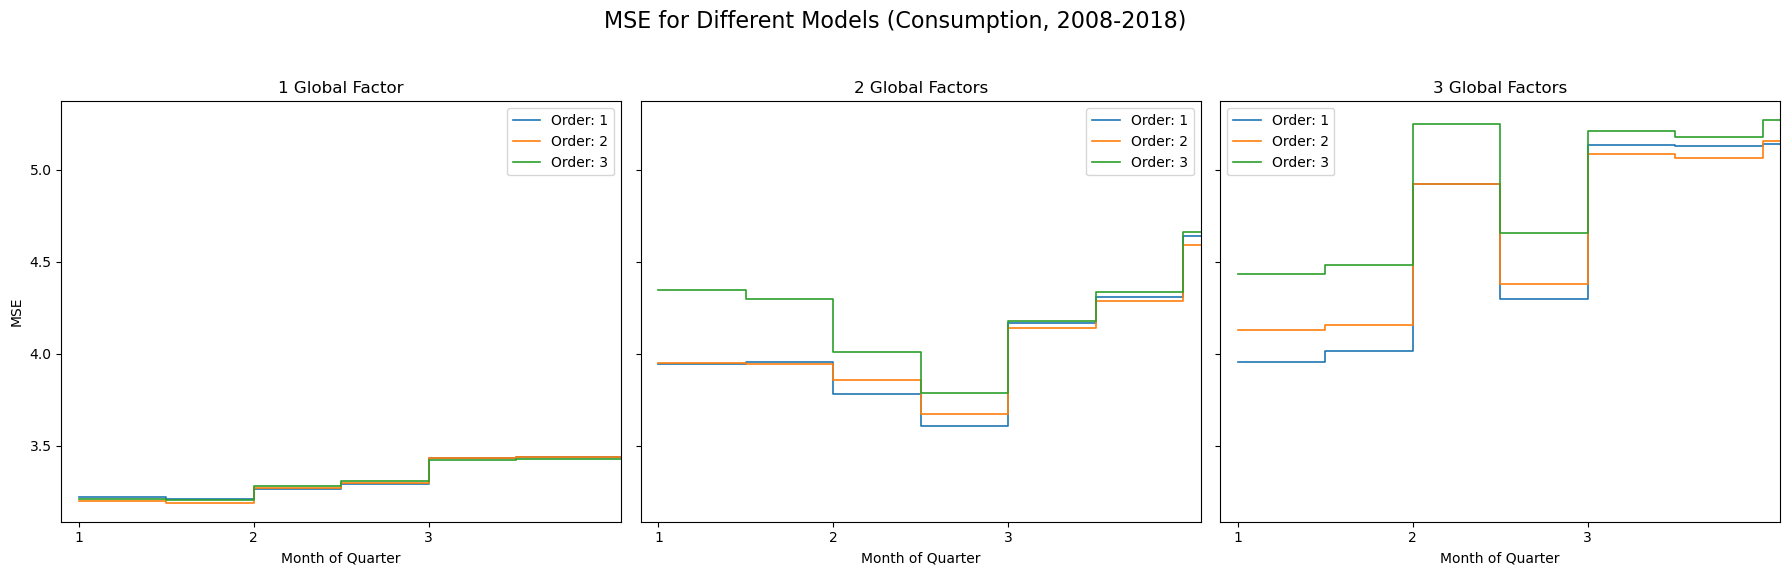

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "100"
source = "all"
selected = "_lag3"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


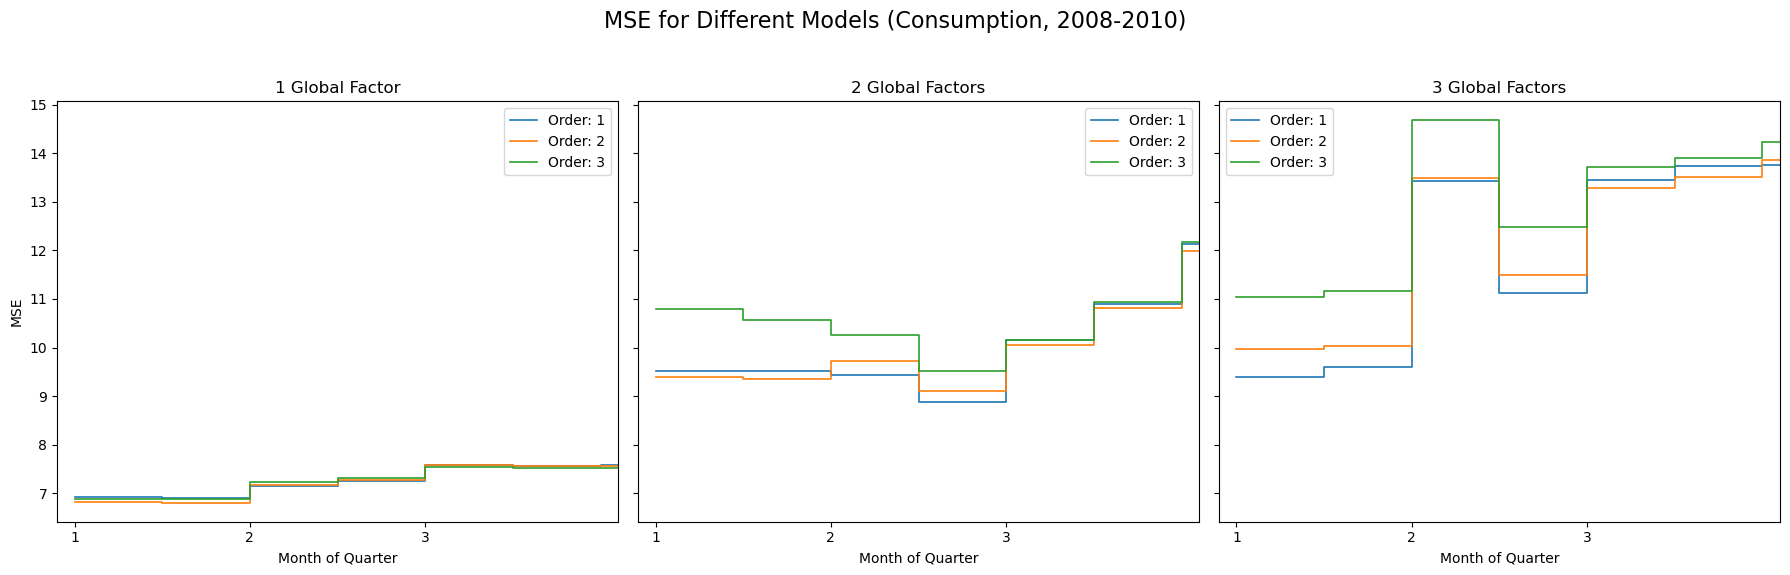

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


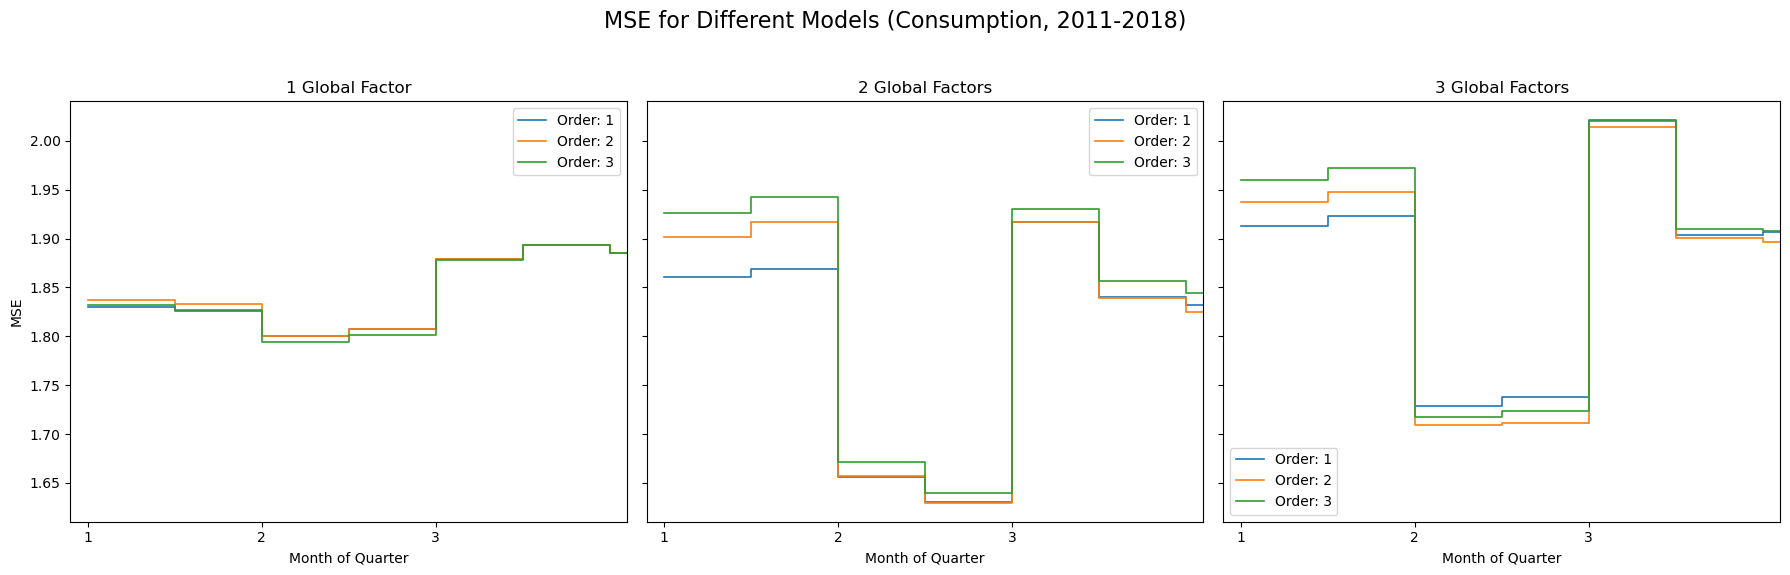

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "100"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


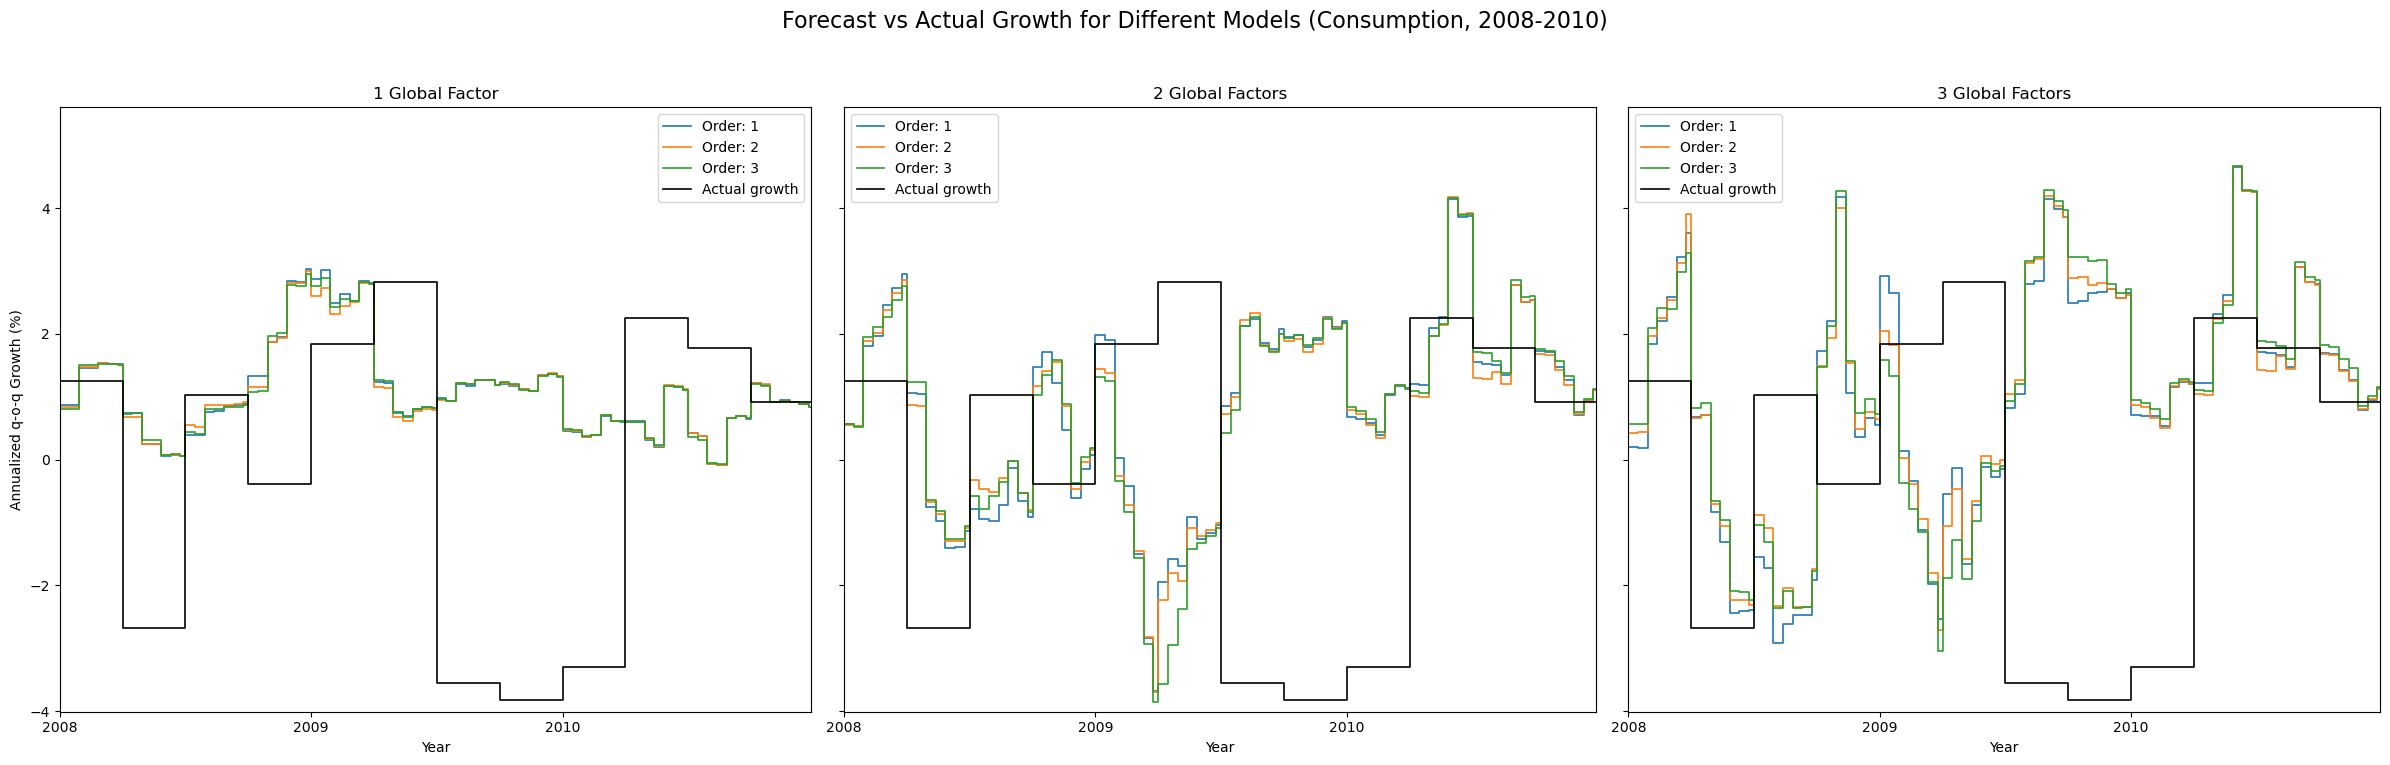

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


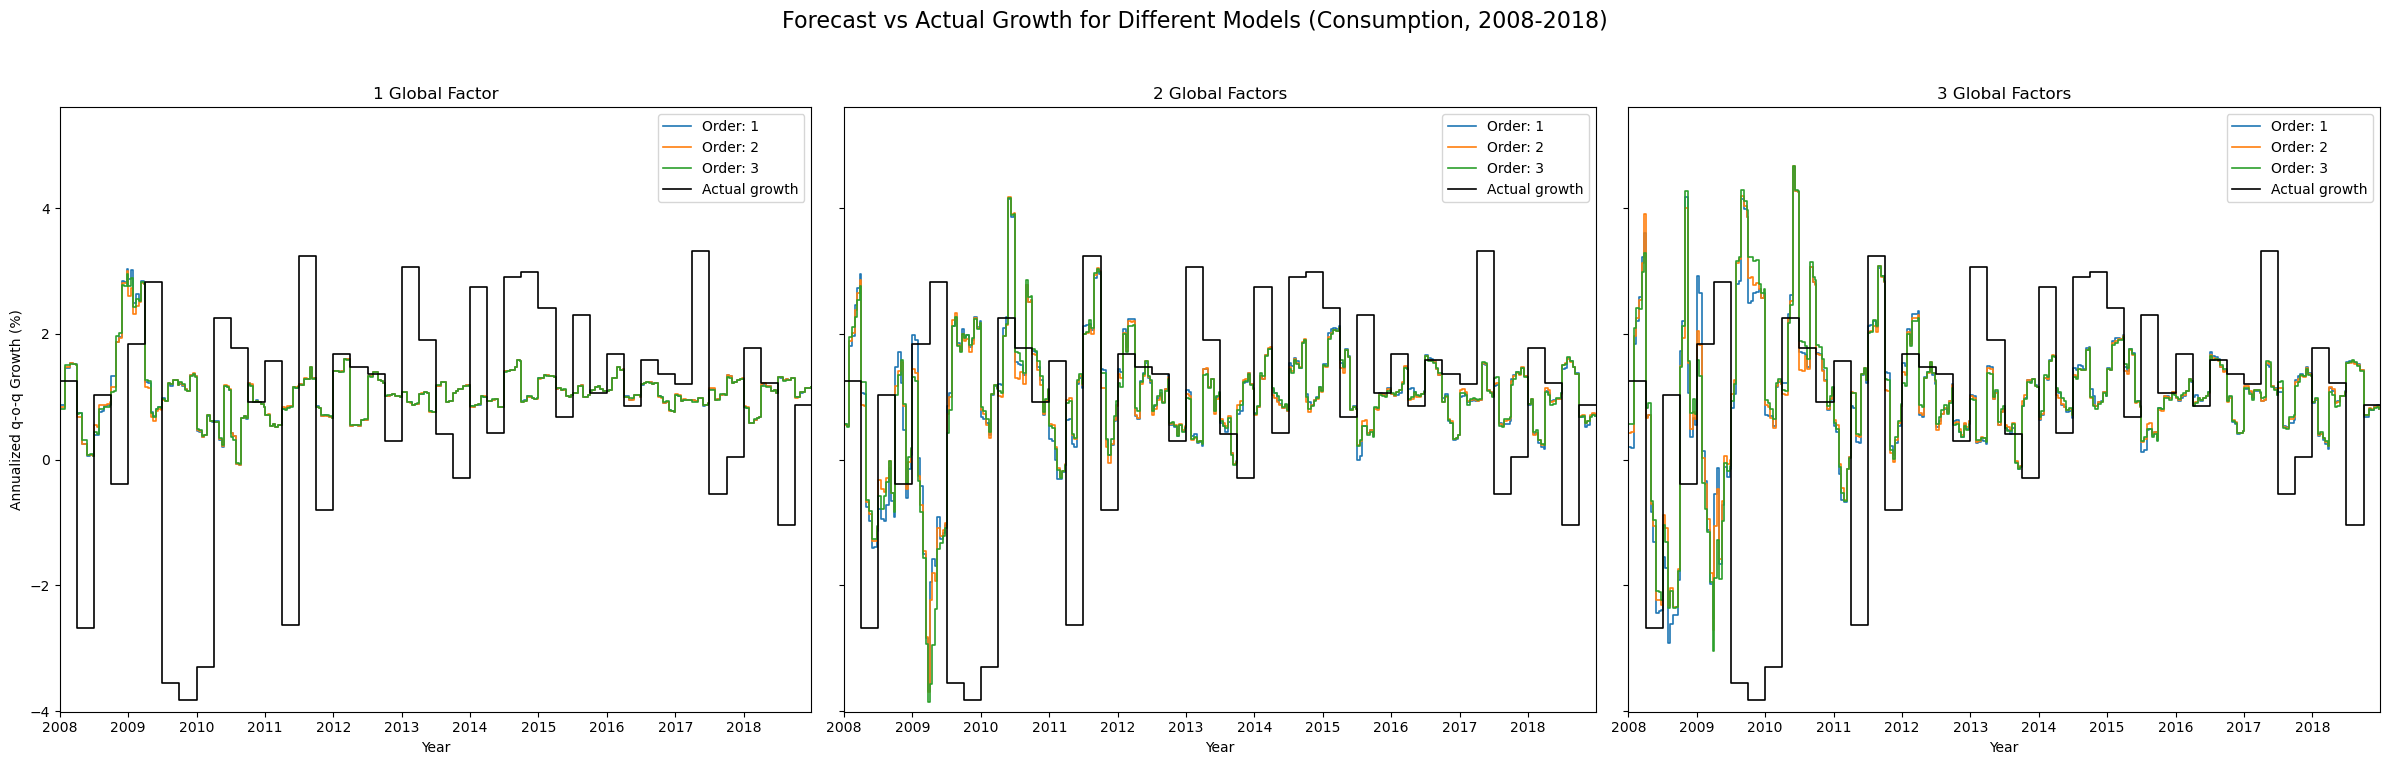

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


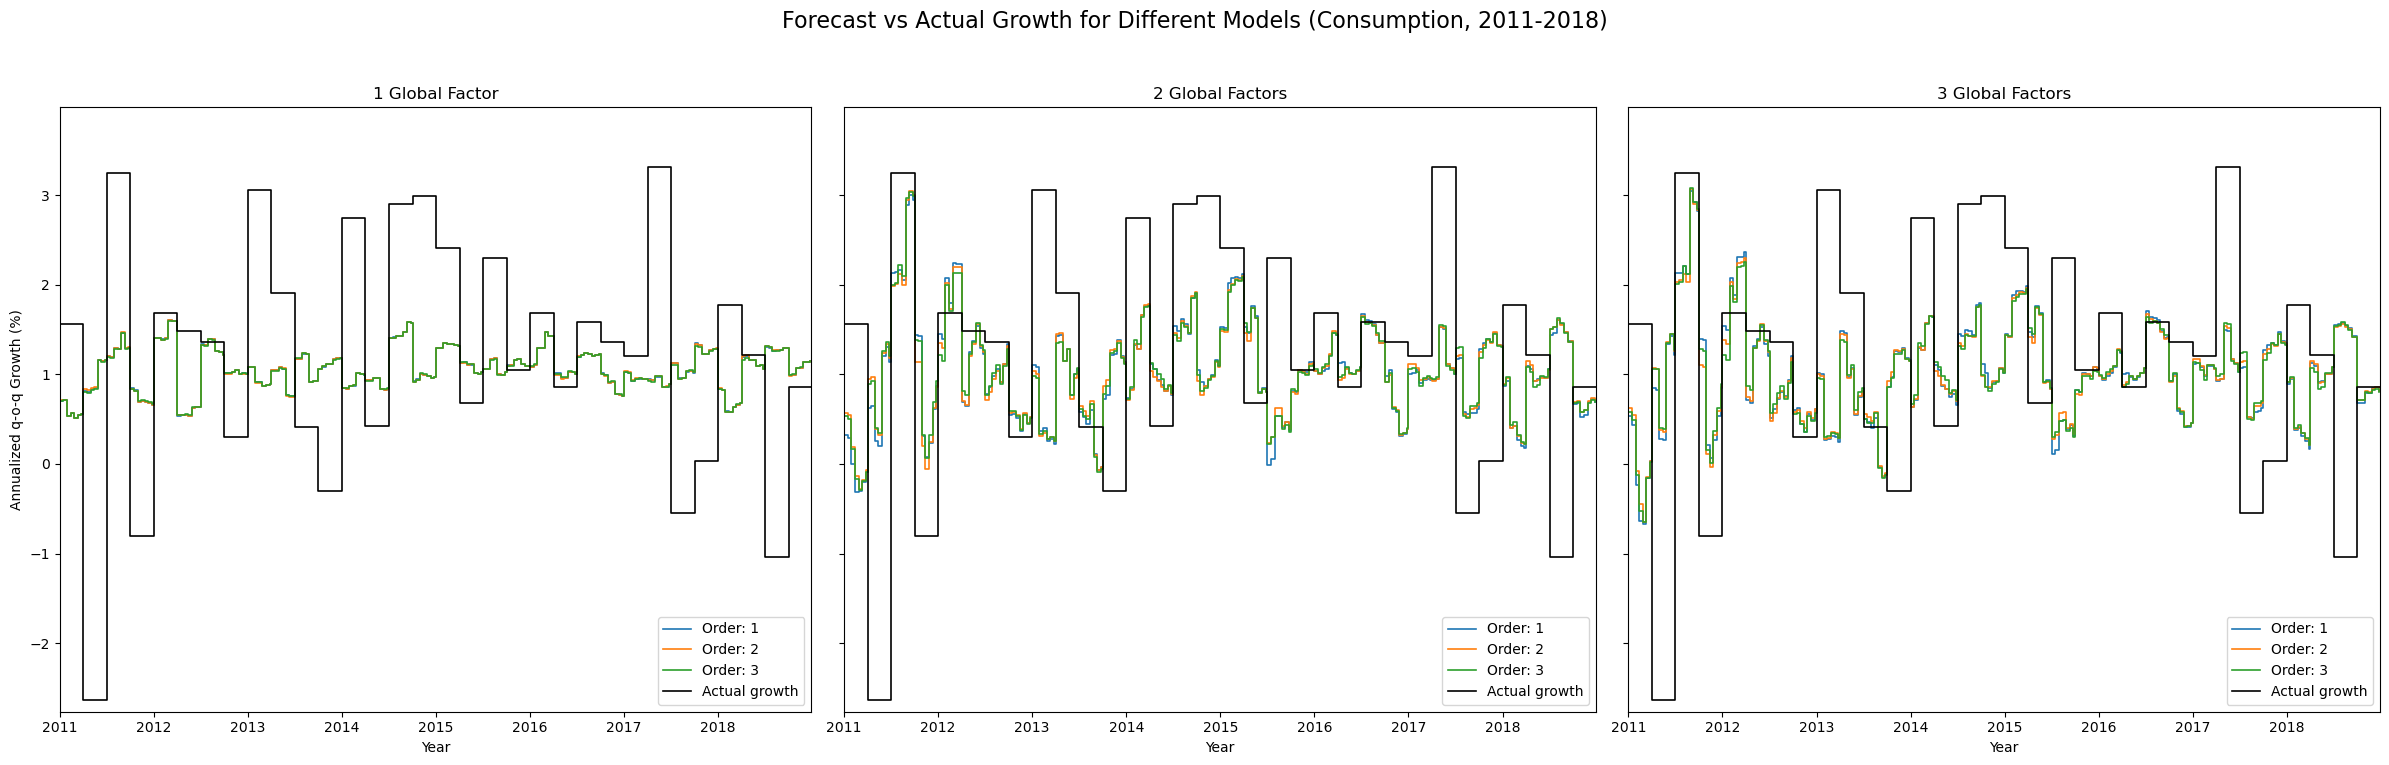

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "100"
source = "all"
selected = "_lag3"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()